##Get the Data from Kaggle

In [6]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#After uploading the kaggle.json file
#Move the file 'kaggle.json' from '/content' to '/kaggle'
!mv /content/kaggle.json /kaggle

#Setting the environment variable 'KAGGLE_CONFIG_DIR' that points to the location of your kaggle.json file.
os.environ['KAGGLE_CONFIG_DIR'] = '/kaggle'

#Downloading the dataset
!kaggle competitions download -c "house-prices-advanced-regression-techniques"

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 78.3MB/s]


In [3]:
#Warning: Your Kaggle API key is readable by other users on this system! To fix this, you can run 'chmod 600 /kaggle/kaggle.json'
!chmod 600 /kaggle/kaggle.json

In [4]:
# Unzip the folder
!unzip /content/house-prices-advanced-regression-techniques.zip

Archive:  /content/house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


##EDA

###   Missing values & Malicious feature columns

In [7]:
df = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
sam_sub = pd.read_csv('/content/sample_submission.csv')

In [8]:
df.tail(10)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1450  1451          90       RL         60.0     9000   Pave   NaN      Reg   
1451  1452          20       RL         78.0     9262   Pave   NaN      Reg   
1452  1453         180       RM         35.0     3675   Pave   NaN      Reg   
1453  1454          20       RL         90.0    17217   Pave   NaN      Reg   
1454  1455          20       FV         62.0     7500   Pave  Pave      Reg   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
1450         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1451         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1452         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1453         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1454         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
1450      9   2009        WD         Normal     136000  
1451      5   2009       New        Partial     287090  
1452      5   2006        WD         Normal     145000  
1453      7   2006        WD        Abnorml      84500  
1454     10   2009        WD         Normal     185000  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[10 rows x 81 columns]

In [9]:
print(df.shape)
df.info()

(1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 1

We can see the columns 'Alley','MasVnrType' , 'PoolQc', 'Fence' and 'MiscFeature' have a lot of null values : at least 60% null-values.
So they cannot be used to fed into our model and we can remove them.

Although, we have the column 'FireplaceQu' with 43.7% null-values (no Fireplace) which means it's biased towards a class but we'll see its other classes variations with the target class before deciding wether to keep it or remove it.

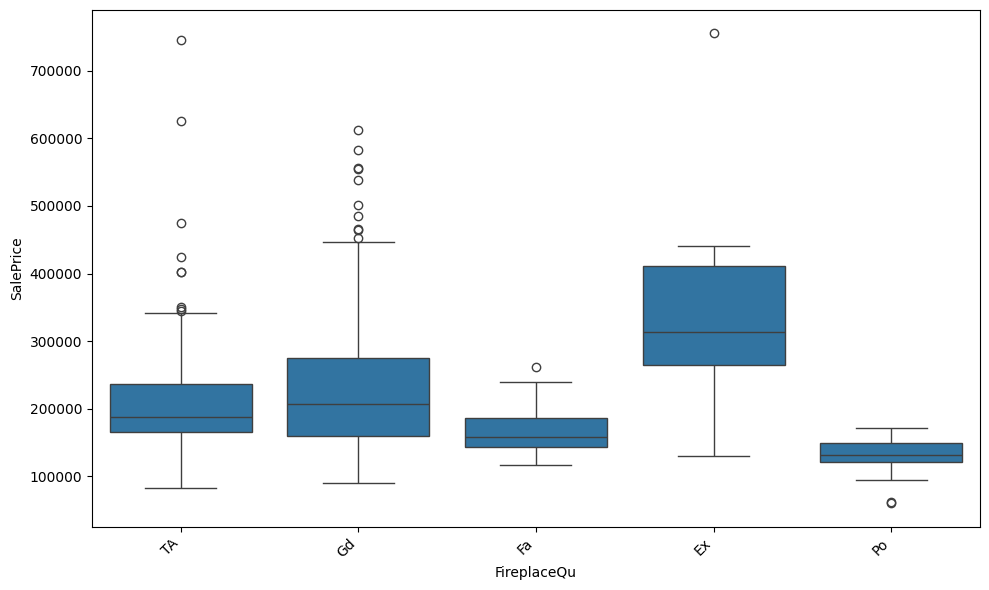

In [10]:
import seaborn as sns

fq= df[df['FireplaceQu'].notna()]
plt.figure(figsize=(10, 6)) #Adjust figure size for better visualization
sns.boxplot(x='FireplaceQu', y='SalePrice', data=fq)
plt.xticks(rotation=45,ha='right') #Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

We can see the diffence in values among the different classes so we will keep it and replace NaN by zero since it means no Fireplace in the house. (see description file)

In [11]:
df['FireplaceQu'].fillna('0', inplace=True)

In [12]:
df.drop(['Alley','MasVnrType', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)

In [13]:
df[df['Condition1'] != df['Condition2']]


Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape  \
1        2          20       RL         80.0     9600   Pave      Reg   
7        8          60       RL          NaN    10382   Pave      IR1   
8        9          50       RM         51.0     6120   Pave      Reg   
18      19          20       RL         66.0    13695   Pave      Reg   
29      30          30       RM         60.0     6324   Pave      IR1   
...    ...         ...      ...          ...      ...    ...      ...   
1403  1404          20       RL         49.0    15256   Pave      IR1   
1404  1405          50       RL         60.0    10410   Pave      Reg   
1427  1428          50       RL         60.0    10930   Pave      Reg   
1430  1431          60       RL         60.0    21930   Pave      IR3   
1438  1439          20       RM         90.0     7407   Pave      Reg   

     LandContour Utilities LotConfig  ... EnclosedPorch 3SsnPorch ScreenPorch  \
1            Lvl    AllPub       FR2  ...             0         0           0   
7            Lvl    AllPub    Corner  ...           228         0           0   
8            Lvl    AllPub    Inside  ...           205         0           0   
18           Lvl    AllPub    Inside  ...             0         0           0   
29           Lvl    AllPub    Inside  ...            87         0           0   
...          ...       ...       ...  ...           ...       ...         ...   
1403         Lvl    AllPub   CulDSac  ...             0         0           0   
1404         Lvl    AllPub    Corner  ...           160         0           0   
1427         Bnk    AllPub    Inside  ...             0         0           0   
1430         Lvl    AllPub    Inside  ...             0         0           0   
1438         Lvl    AllPub    Inside  ...           158         0           0   

     PoolArea MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
1           0       0      5    2007        WD         Normal     181500  
7           0     350     11    2009        WD         Normal     200000  
8           0       0      4    2008        WD        Abnorml     129900  
18          0       0      6    2008        WD         Normal     159000  
29          0       0      5    2008        WD         Normal      68500  
...       ...     ...    ...     ...       ...            ...        ...  
1403        0       0      8    2007        WD         Normal     282922  
1404        0       0      1    2006        WD         Family     105000  
1427        0       0      4    2008        WD         Normal     140000  
1430        0       0      7    2006        WD         Normal     192140  
1438        0       0      4    2010        WD         Normal     149700  

[195 rows x 76 columns]

We can see above that 'condition1' has more variablity than 'condition2' which repeated the same value 'norm' very often. They both have the same description in the description file. So we're mostly likely to believe that 'condition' is more accurate and we can remove 'condition2'.

In [14]:
df.drop(['Condition2'], axis=1, inplace=True)

In [15]:
df['MasVnrArea'].value_counts()


MasVnrArea
0.0      861
180.0      8
72.0       8
108.0      8
120.0      7
        ... 
562.0      1
89.0       1
921.0      1
762.0      1
119.0      1
Name: count, Length: 327, dtype: int64

it's normal to see zeros in 'MasVnrArea' (stands for Masonry Veneer Area) cz it just means that these houses don't have any stone or brick veneer on their exterior. But since it's similar for mostly all the data so it's not gonna be a good source of information for the model.
So we can remove it.

it's also the same for 'LowQualFinSF', 'BsmtHalfBath' , 'BsmtFullBath', 'HalfBath', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch' columns.

In [16]:
df.drop(['MasVnrArea', 'LowQualFinSF','BsmtHalfBath' , 'BsmtFullBath', 'HalfBath', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis=1, inplace=True)

In [17]:
'''The four columns 'BsmtUnfSF' ,'BsmtFinSF1', 'BsmtFinSF2' and 'TotalBsmtSF' are all giving the same information
which is finished living area in basement with only one difference and that is the portion. But we can directly use the
TotalBsmSF and remove the others bcz we don't wanna add complexity to the model with no different and valuable information'''

df.drop(['BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2'], axis=1, inplace=True)

In [18]:
correlation = df['GarageYrBlt'].corr(df['YearBuilt'])
print(correlation)

0.8256674841743421


Since we have a high correlation here so we don't need both columns and we'll settle for the 'YearBuilt' column.

In [19]:
df['PoolArea'].value_counts()

PoolArea
0      1453
512       1
648       1
576       1
555       1
480       1
519       1
738       1
Name: count, dtype: int64

Since almost all our dataset does not have pools we can simply remove the column.And any other column related to pools such as 'PoolQc' (already removed).

In [20]:
df.drop(['PoolArea'], axis=1, inplace=True)

In [21]:
df['MiscVal'].value_counts()

MiscVal
0        1408
400        11
500         8
700         5
450         4
600         4
2000        4
1200        2
480         2
15500       1
800         1
350         1
3500        1
1300        1
54          1
620         1
560         1
1400        1
8300        1
1150        1
2500        1
Name: count, dtype: int64

Even though we can see 96% of the data does not have 'MiscVal' Miscellaneous Value (refers to the estimated dollar value of additional features that are not captured by other specific features in the data set.) but we need to make sure that the rest were not really big enough to affect the original price of the house and that's why we'll make our proportions :

In [22]:
miscvals = df[df['MiscVal'] != 0]
proportions = miscvals['MiscVal']/miscvals['SalePrice']
proportions.max()

0.10231023102310231

It's only 10% for one data point. We'll remove it for sure

In [23]:
df.drop(['MiscVal'], axis=1, inplace=True)

#and of course we don't need the Id column
df.drop(['Id'], axis=1, inplace=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 59 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  BldgType       1460 non-null   object 
 13  HouseStyle     1460 non-null   object 
 14  OverallQual    1460 non-null   int64  
 15  OverallCond    1460 non-null   int64  
 16  YearBuilt      1460 non-null   int64  
 17  YearRemodAdd   1460 non-null   int64  
 18  RoofStyl

Except for 'FirePlaceQu', we notice that all the features left with null values have at maximum 5% null values(for the object type columns) and 17.7% null values in the column 'LotFrontage' which is numerical.
We'll replace these null-values by the mean or the mode respetively.

In [25]:
#Getting a list of the names of the categorical columns we want to replace their null-values with the respective mode
categorical_with_null = []
categorical_indexes = [26,27,28,29,30,35,47,49,52,53] #it's just easier than writing the columns names
for i in categorical_indexes:
  categorical_with_null.append(df.columns[i])

#For the numerical it could be done manually
numerical_with_null = ['LotFrontage', 'GarageYrBlt']

#Filling null-values for both
for column in categorical_with_null:
  df[column].fillna(df[column].mode()[0], inplace=True)
for column in numerical_with_null:
  df[column].fillna(df[column].mean(), inplace=True)


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 59 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  BldgType       1460 non-null   object 
 13  HouseStyle     1460 non-null   object 
 14  OverallQual    1460 non-null   int64  
 15  OverallCond    1460 non-null   int64  
 16  YearBuilt      1460 non-null   int64  
 17  YearRemodAdd   1460 non-null   int64  
 18  RoofStyl

###Plotting the relation between the target class and each feature

In [27]:
# features = df.drop(['SalePrice','Id',] , axis=1)
# names = list(features.columns)  #So we can specify the convenient type of plot lately for each
# plot_kind={}  #Using Dictionnary to specify the plotting type
# for col in names:
#   count = df[col].nunique()
#   if count>25:              #The categorical column 'Neighborhood' has the biggest number of unique values among all, and it's 25.
#     plot_kind[col]='scat'
#   else:
#     plot_kind[col]='bar'


# fig, ax = plt.subplots(int(np.ceil(len(names)/2)), 2 , figsize=(100,400))
# Nmax = features.shape[1] #How many features we want to plot its correlation with the output column 'SalePrice'
# i ,j ,n =0 ,0 ,0

# while n <= Nmax-1: #looping over the features to plot the correlations

#   if plot_kind[names[n]] == 'scat' :
#     #Using scatter plot for the continueously numerical columns
#     ax[j][i].scatter(df[names[n]], df['SalePrice'])
#     ax[j][i].set_xlabel(names[n])

#   if plot_kind[names[n]] == 'bar':
#     df[[names[n],'SalePrice']].groupby(names[n])['SalePrice'].value_counts(normalize=True).unstack().plot(kind='bar',color='blue', legend=False, ax=ax[j][i])
#     ax[j][i].set_xlabel(names[n])


#   ax[j][i].set_title(f'Relationship between {names[n]} and SalePrice')
#   ax[j][i].set_ylabel('SalePrice')

#   if i==1 :
#     j+=1
#     i= 0
#   else:
#     i+=1
#   n+=1


# plt.tight_layout()
# plt.show()

####For numerical features

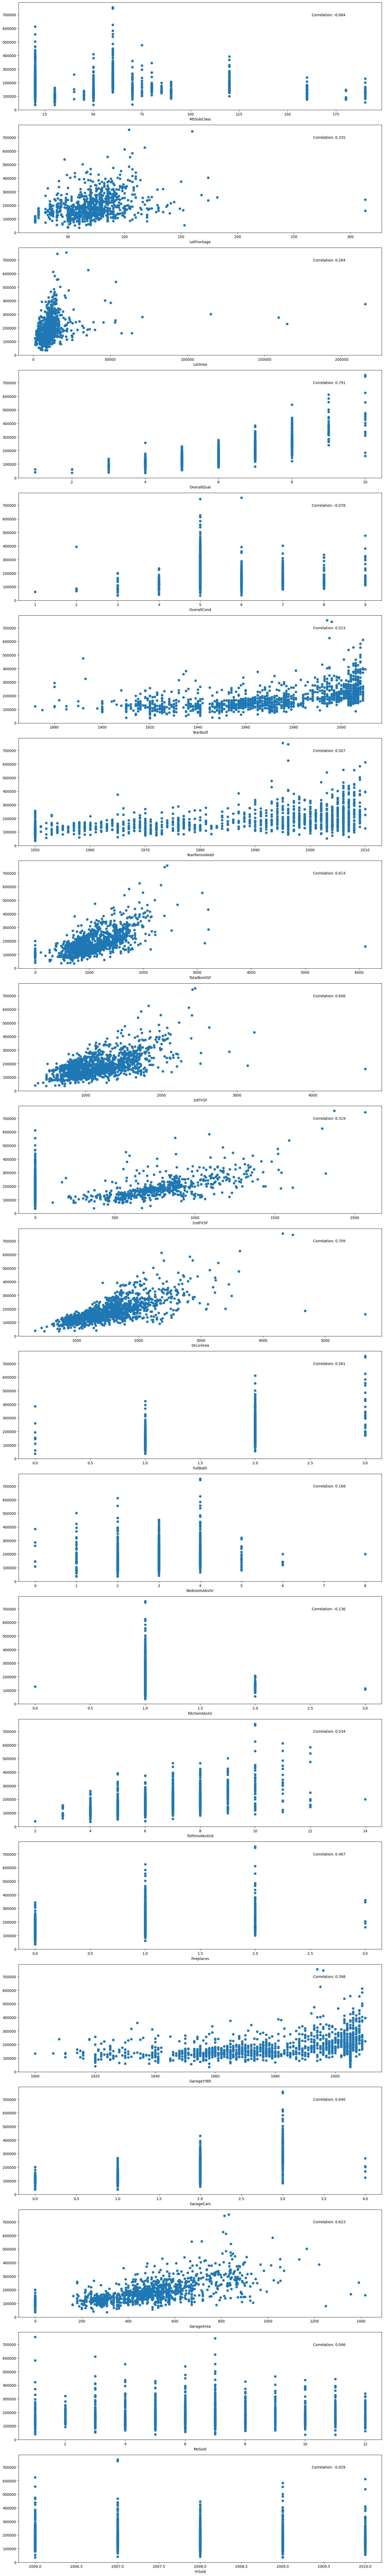

In [28]:
features = df.drop(['SalePrice'] , axis=1)
num_cols = [col for col in features.columns if features[col].dtype != "object"]

fig, ax = plt.subplots(len(num_cols) , figsize=(15,100))

for i in range(len(num_cols)):
  ax[i].scatter(df[num_cols[i]], df['SalePrice'])
  ax[i].set_xlabel(num_cols[i])
  correlation = df[num_cols[i]].corr(df['SalePrice'])
  ax[i].text(0.9, 0.9, f'Correlation: {correlation:.3f}', transform=ax[i].transAxes, ha='right', va='top')

plt.tight_layout()
plt.show()

We are cautious that some numerical features are basically categorical features and we won't depend on the correlation coefficient in that case. We will use our corr.coe. as a supportive measurement for the real numerical plots.
Let's list the features that did not show any difference in their values along with the target class so we can get rid of them, and this will be partitioned between :

categorical cols --> 'BedroomAbvGr' , 'MoSold' , 'YrSold'

numerical cols ---> 'LotArea' , '2ndFlrSF' , 'GarageYrBlt'


Reasons we removed each :


0. 'LotArea' --> a lot of the same area has a very big range price.
1. '2ndFlrSF' --> ALready more than half the data does not include houses wth
second floor , and the other part shows in the plot that it does not have a big influence on the price as other features.
2. 'BedroomAbvGr' --> We already don't have equal distribution along the different number of rooms so we can make a fair comparison. but among the most existed ones we can see it's not an important difference in price.
3. 'GarageYrBlt' --> very small amount of data got an increased price but the majority stayed the same
4. 'MoSold' --> equally distributed prices along the months
5. 'YrSold' --> equally distributed prices along the years

In [29]:
df.drop(['LotArea', '2ndFlrSF', 'BedroomAbvGr', 'GarageYrBlt', 'MoSold', 'YrSold'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 53 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   Street         1460 non-null   object 
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   Utilities      1460 non-null   object 
 7   LotConfig      1460 non-null   object 
 8   LandSlope      1460 non-null   object 
 9   Neighborhood   1460 non-null   object 
 10  Condition1     1460 non-null   object 
 11  BldgType       1460 non-null   object 
 12  HouseStyle     1460 non-null   object 
 13  OverallQual    1460 non-null   int64  
 14  OverallCond    1460 non-null   int64  
 15  YearBuilt      1460 non-null   int64  
 16  YearRemodAdd   1460 non-null   int64  
 17  RoofStyle      1460 non-null   object 
 18  RoofMatl

####For object features

<ipython-input-30-8fd44afdf909>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-30-8fd44afdf909>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-30-8fd44afdf909>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-30-8fd44afdf909>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-30-8fd44afdf909>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-30-8fd44afdf909>:13: UserWarning: FixedFormatter should only

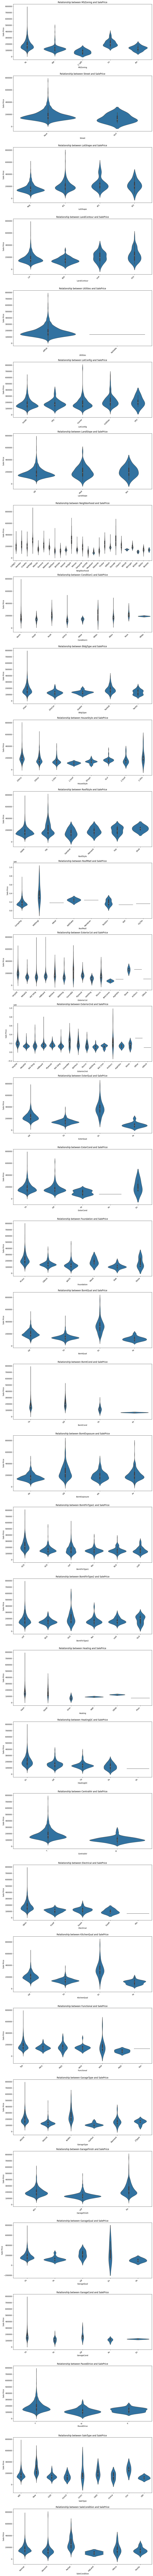

In [30]:
object_cols = [col for col in features.columns if features[col].dtype == "object" and col != 'FireplaceQu']

fig, ax = plt.subplots(len(object_cols), figsize=(12, 200))
for i in range(len(object_cols)):
    # Create violin plot using seaborn
    sns.violinplot(x=object_cols[i], y='SalePrice', data=df, ax=ax[i], inner='box')

    ax[i].set_xlabel(object_cols[i])
    ax[i].set_title(f'Relationship between {object_cols[i]} and SalePrice')
    ax[i].set_ylabel('Sale Price')

    # Rotate x-axis labels for readability
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


We remove the features which do not have a noticeable variation among their classes relatice to the price of the houses.

These are : 'LandSlope' , 'BsmtFinType2'.

And unfair analysis on : 'Utilities','BsmtCond','CentralAir', 'Street', 'RoofMatl'

In [31]:
df.drop(['LandSlope', 'BsmtFinType2'], axis=1, inplace=True)

In [32]:
unfair_comparison = ['Utilities','BsmtCond','CentralAir', 'Street', 'RoofMatl']
for col in unfair_comparison:
  print(col)
  print(df[col].value_counts())
  print('\n')

Utilities
Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64


BsmtCond
BsmtCond
TA    1348
Gd      65
Fa      45
Po       2
Name: count, dtype: int64


CentralAir
CentralAir
Y    1365
N      95
Name: count, dtype: int64


Street
Street
Pave    1454
Grvl       6
Name: count, dtype: int64


RoofMatl
RoofMatl
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: count, dtype: int64




We cannot make a fair analyse on these features bcz of its bias towards a single class more than the other... It's better to remove them.

In [33]:
df.drop(['Utilities','BsmtCond','CentralAir','Street','RoofMatl'], axis=1, inplace=True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 46 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotShape       1460 non-null   object 
 4   LandContour    1460 non-null   object 
 5   LotConfig      1460 non-null   object 
 6   Neighborhood   1460 non-null   object 
 7   Condition1     1460 non-null   object 
 8   BldgType       1460 non-null   object 
 9   HouseStyle     1460 non-null   object 
 10  OverallQual    1460 non-null   int64  
 11  OverallCond    1460 non-null   int64  
 12  YearBuilt      1460 non-null   int64  
 13  YearRemodAdd   1460 non-null   int64  
 14  RoofStyle      1460 non-null   object 
 15  Exterior1st    1460 non-null   object 
 16  Exterior2nd    1460 non-null   object 
 17  ExterQual      1460 non-null   object 
 18  ExterCon

#Data Preprocessing and Transformation


##Encoding the categorical features

In [35]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df1 = df.copy()
#Our categorical features are divided into 2 kinds : Hierarchical and non-Hirarchical (various)
#We excluded the column 'FireplaceQu'
hiera_ftrs = ['LotShape', 'LandContour', 'BldgType', 'HouseStyle', 'FireplaceQu', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual','BsmtExposure',
                  'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual','GarageCond','PavedDrive']

vari_ftrs = ['MSSubClass', 'MSZoning', 'LotConfig', 'Neighborhood', 'Condition1', 'RoofStyle',
             'Exterior1st', 'Exterior2nd','Foundation', 'Heating', 'Electrical', 'SaleType', 'SaleCondition']

categ_ftrs = hiera_ftrs + vari_ftrs

for feature in categ_ftrs:
  df1[feature] = le.fit_transform(df1[feature])


In [36]:
df1.head().iloc[: , 32:]

TotRmsAbvGrd  Functional  Fireplaces  FireplaceQu  GarageType  \
0             8           6           0            0           1   
1             6           6           1            5           1   
2             6           6           1            5           1   
3             7           6           1            3           5   
4             9           6           1            5           1   

   GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond  PavedDrive  \
0             1           2         548           4           4           2   
1             1           2         460           4           4           2   
2             1           2         608           4           4           2   
3             2           3         642           4           4           2   
4             1           3         836           4           4           2   

   SaleType  SaleCondition  SalePrice  
0         8              4     208500  
1         8              4     181500  
2         8              4     223500  
3         8              0     140000  
4         8              4     250000

##Normalizing the data

In [37]:
df1_max = df1.max()
df1_max

MSSubClass           14.0
MSZoning              4.0
LotFrontage         313.0
LotShape              3.0
LandContour           3.0
LotConfig             4.0
Neighborhood         24.0
Condition1            8.0
BldgType              4.0
HouseStyle            7.0
OverallQual           9.0
OverallCond           8.0
YearBuilt          2010.0
YearRemodAdd       2010.0
RoofStyle             5.0
Exterior1st          14.0
Exterior2nd          15.0
ExterQual             3.0
ExterCond             4.0
Foundation            5.0
BsmtQual              4.0
BsmtExposure          3.0
BsmtFinType1          5.0
TotalBsmtSF        6110.0
Heating               5.0
HeatingQC             4.0
Electrical            5.0
1stFlrSF           4692.0
GrLivArea          5642.0
FullBath              3.0
KitchenAbvGr          3.0
KitchenQual           3.0
TotRmsAbvGrd         14.0
Functional            6.0
Fireplaces            3.0
FireplaceQu           5.0
GarageType            6.0
GarageFinish          3.0
GarageCars  

In [38]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df2 = scaler.fit_transform(df1)
df2 = pd.DataFrame(df2, columns=df1.columns)

df2.head()


MSSubClass  MSZoning  LotFrontage  LotShape  LandContour  LotConfig  \
0    0.357143      0.75     0.150685       1.0          1.0        1.0   
1    0.000000      0.75     0.202055       1.0          1.0        0.5   
2    0.357143      0.75     0.160959       0.0          1.0        1.0   
3    0.428571      0.75     0.133562       0.0          1.0        0.0   
4    0.357143      0.75     0.215753       0.0          1.0        0.5   

   Neighborhood  Condition1  BldgType  HouseStyle  ...  GarageType  \
0      0.208333       0.250       0.0    0.714286  ...    0.166667   
1      1.000000       0.125       0.0    0.285714  ...    0.166667   
2      0.208333       0.250       0.0    0.714286  ...    0.166667   
3      0.250000       0.250       0.0    0.714286  ...    0.833333   
4      0.625000       0.250       0.0    0.714286  ...    0.166667   

   GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond  PavedDrive  \
0      0.333333        0.50    0.386460         0.8         1.0         1.0   
1      0.333333        0.50    0.324401         0.8         1.0         1.0   
2      0.333333        0.50    0.428773         0.8         1.0         1.0   
3      0.666667        0.75    0.452750         0.8         1.0         1.0   
4      0.333333        0.75    0.589563         0.8         1.0         1.0   

   SaleType  SaleCondition  SalePrice  
0       1.0            0.8   0.241078  
1       1.0            0.8   0.203583  
2       1.0            0.8   0.261908  
3       1.0            0.0   0.145952  
4       1.0            0.8   0.298709  

[5 rows x 46 columns]

In [39]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 46 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   float64
 1   MSZoning       1460 non-null   float64
 2   LotFrontage    1460 non-null   float64
 3   LotShape       1460 non-null   float64
 4   LandContour    1460 non-null   float64
 5   LotConfig      1460 non-null   float64
 6   Neighborhood   1460 non-null   float64
 7   Condition1     1460 non-null   float64
 8   BldgType       1460 non-null   float64
 9   HouseStyle     1460 non-null   float64
 10  OverallQual    1460 non-null   float64
 11  OverallCond    1460 non-null   float64
 12  YearBuilt      1460 non-null   float64
 13  YearRemodAdd   1460 non-null   float64
 14  RoofStyle      1460 non-null   float64
 15  Exterior1st    1460 non-null   float64
 16  Exterior2nd    1460 non-null   float64
 17  ExterQual      1460 non-null   float64
 18  ExterCon

#Model training and testing


##Splitting data

In [40]:
from sklearn.model_selection import train_test_split
X = df2.iloc[:, :-1]
y = df2.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1168, 45) (1168,)
(292, 45) (292,)


##Simple Linear Regression Model

In [39]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)
print('Model score {}'.format(model.score(x_test,y_test)))

Model score 0.8393372523042643


In [40]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(x_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Calculate Root Mean Squared Error
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Root Mean Squared Error:', rmse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)

Mean Squared Error: 0.0023765305555632486
Root Mean Squared Error: 0.048749672363650284
R-squared: 0.8393372523042643


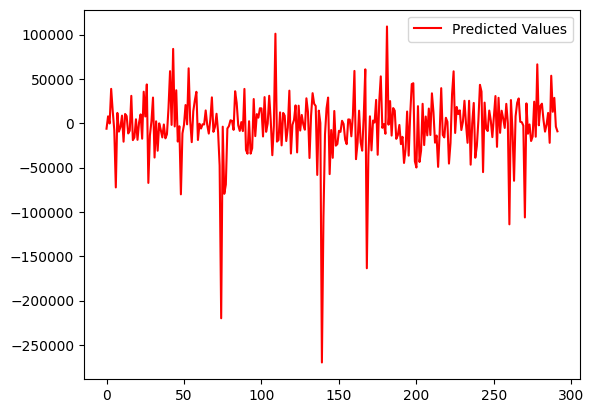

In [41]:
x_coords = range(len(y_pred))

# Plot the difference between predicted values and true values
plt.plot(x_coords, (y_pred - y_test)*df1_max[-1], color='red', label='Predicted Values')

# Add legend and show plot
plt.legend()
plt.show()

##Linear Regression Big Model / DL

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


def create_model():

  model = Sequential()
  model.add(Dense(100, input_dim=45, activation="relu"))
  model.add(Dense(70, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(30, activation="relu"))
  model.add(Dropout(0.15))
  model.add(Dense(20, activation="relu"))
  model.add(Dense(1, activation="linear"))

  model.compile(loss="mean_squared_error", optimizer="adam")

  return model

dlmodel = create_model()
history = dlmodel.fit(x_train, y_train, epochs=200, batch_size=20, validation_split=0.2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 0.0735 - val_loss: 0.0050
Epoch 2/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0076 - val_loss: 0.0037
Epoch 3/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - val_loss: 0.0029
Epoch 4/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - val_loss: 0.0039
Epoch 5/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - val_loss: 0.0024
Epoch 6/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 7/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 8/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 9/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 10/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 11/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 12/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


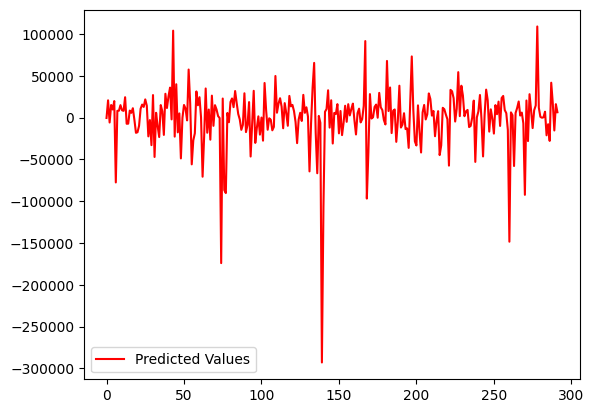

In [48]:
# Predict values and multiply by df1_max[-1]
predicted_values = dlmodel.predict(x_test).flatten() * df1_max[-1]

# Assuming y_test is a numpy array, multiply it by df1_max[-1] and flatten it
true_values = (y_test * df1_max[-1])

# Generate x-coordinates for the bars
x_coords = range(len(predicted_values))

# Plot the predicted values
plt.plot(x_coords, predicted_values - true_values, color='red', label='Predicted Values')


# Add legend and show plot
plt.legend()
plt.show()

<ipython-input-49-2fbe1f9d6e57>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predicted_values - true_values, hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3}, color='blue')
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


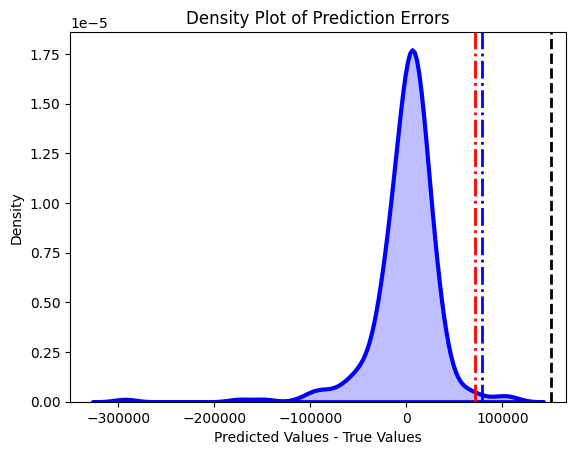

In [49]:
sns.distplot(predicted_values - true_values, hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3}, color='blue')

# Add lines for the mean and standard deviation
mean = predicted_values.mean()
std = predicted_values.std()
plt.axvline(mean, color='black', linestyle='--', linewidth=2)
plt.axvline(std, color='red', linestyle='-.', linewidth=2)
plt.axvline(mean - std, color='blue', linestyle='-.', linewidth=2)

# Set labels and title
plt.xlabel('Predicted Values - True Values')
plt.ylabel('Density')
plt.title('Density Plot of Prediction Errors')

# Show the plot
plt.show()

#Additional Work : Trying XGBoost


In [50]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Convert the data into DMatrix format, which is required for XGBoost
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

# Set XGBoost parameters for linear regression
params = {
    'objective': 'reg:squarederror',  # Objective function for linear regression
    'eval_metric': 'rmse'              # Evaluation metric: root mean squared error
}

# Train the XGBoost model
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test set
y_pred_xgb = bst.predict(dtest)

# Calculate RMSE (Root Mean Squared Error) as the evaluation metric
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"RMSE: {rmse}")
print(f'MSE: {rmse**2}')

RMSE: 0.039279749565018826
MSE: 0.0015428987258905966


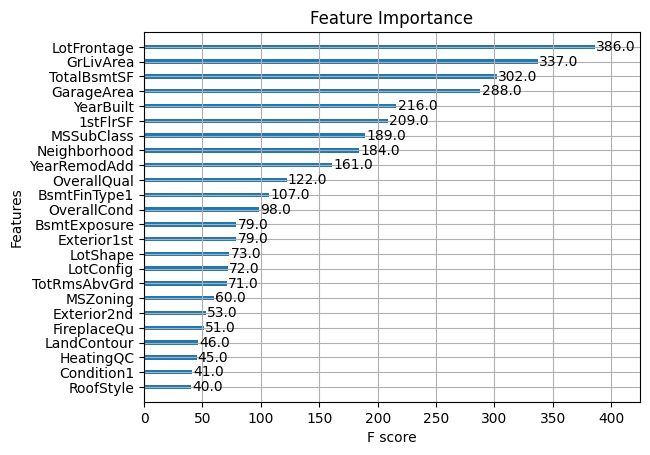

<Figure size 1000x32600 with 0 Axes>

In [51]:
# Plot feature importance

xgb.plot_importance(bst, importance_type='weight', height=0.3, show_values=True, max_num_features=24)
plt.title('Feature Importance')
plt.figure(figsize=(10, 326))
plt.show()


In [52]:
# Get feature importance
importance = bst.get_score(importance_type='weight')

# Convert importance dictionary to list of tuples (feature, score)
importance_list = [(feature, score) for feature, score in importance.items()]

# Filter features with fscore greater than 100
filtered_features = [(feature, score) for feature, score in importance_list if score > 75]

print("Features with fscore greater than 50:")
for feature, score in filtered_features:
    print(f"{feature}: {score}")

Features with fscore greater than 50:
MSSubClass: 189.0
LotFrontage: 386.0
Neighborhood: 184.0
OverallQual: 122.0
OverallCond: 98.0
YearBuilt: 216.0
YearRemodAdd: 161.0
Exterior1st: 79.0
BsmtExposure: 79.0
BsmtFinType1: 107.0
TotalBsmtSF: 302.0
1stFlrSF: 209.0
GrLivArea: 337.0
GarageArea: 288.0


In [53]:
indexes = [df1.columns.get_loc(ft) for ft,_ in filtered_features]

x_train_filtered = x_train.iloc[:, indexes]
x_test_filtered = x_test.iloc[:, indexes]

In [54]:
# Convert the data into DMatrix format, which is required for XGBoost
dtrain1 = xgb.DMatrix(x_train_filtered, label=y_train)
dtest1 = xgb.DMatrix(x_test_filtered, label=y_test)

# Set XGBoost parameters for linear regression
params1 = {
    'objective': 'reg:squarederror',  # Objective function for linear regression
    'eval_metric': 'rmse'              # Evaluation metric: root mean squared error
}

# Train the XGBoost model
num_rounds1 = 100
bst1 = xgb.train(params1, dtrain1, num_rounds1)

# Make predictions on the test set
y_pred_xgb1 = bst1.predict(dtest1)

# Calculate RMSE (Root Mean Squared Error) as the evaluation metric
rmse1 = np.sqrt(mean_squared_error(y_test, y_pred_xgb1))
print(f"RMSE: {rmse1}")
print(f'MSE: {rmse1**2}')

RMSE: 0.03978544266895085
MSE: 0.0015828814483643749


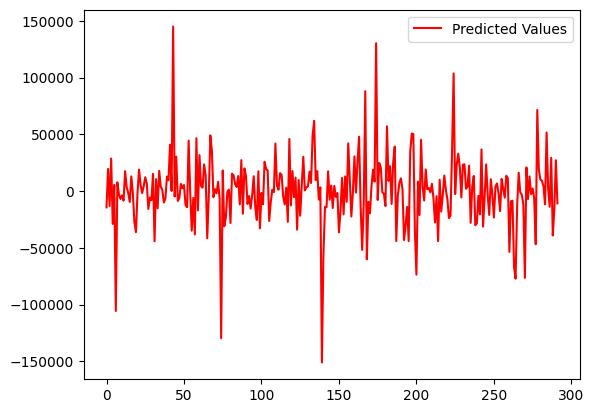

In [55]:
x_coords_xgb1 = range(len(y_pred_xgb1))

# Plot the difference between predicted values and true values
plt.plot(x_coords, (y_pred_xgb1 - y_test)*df1_max[-1], color='red', label='Predicted Values')

# Add legend and show plot
plt.legend()
plt.show()

#Using the filtered features by XGBoost for a DL Regression model

In [56]:
def create_model1():

  model = Sequential()
  model.add(Dense(50, input_dim= x_train_filtered.shape[1], activation="relu"))
  # model.add(Dense(30, activation="relu"))
  model.add(Dropout(0.1))
  model.add(Dense(25, activation="relu"))
  model.add(Dense(1, activation="linear"))

  model.compile(loss="mean_squared_error", optimizer="adam")

  return model

In [58]:
!pip install scikeras

In [62]:

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
# from some_module import keras_model_object
# Define the grid of hyperparameters to search
param_grid = {
    'batch_size': [16 ,10, 8],
    'epochs': [100,150,200]
}

# Wrap your Keras model with KerasRegressor
flt_model_wrapped = KerasRegressor(build_fn=create_model1)

# Create the GridSearchCV object
grid_search = GridSearchCV(flt_model_wrapped, param_grid, cv=3, scoring='neg_mean_squared_error') # Add scoring metric

# Fit the grid search object to the data
grid_search.fit(x_train_filtered, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Print the best hyperparameters
print("Best hyperparameters:")
print(best_params)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.1105
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0097
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0068
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0061
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051
Epoch 8/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041
Epoch 9/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041
Epoch 10/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 11/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039
Epoch 12/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027
Epoch 13/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030
Epoch 14/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032
Epoch 15/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034
Epoch 16/100
78

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0145
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 8/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 9/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028
Epoch 10/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027
Epoch 11/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021
Epoch 12/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028
Epoch 13/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 14/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022
Epoch 15/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021
Epoch 16/100
78

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0187
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 8/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032
Epoch 9/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 10/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 11/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 12/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 13/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 14/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025
Epoch 15/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028
Epoch 16/100
78

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0164
Epoch 2/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073
Epoch 3/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050
Epoch 4/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0044
Epoch 5/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036
Epoch 6/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0044
Epoch 7/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 8/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037
Epoch 9/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 10/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032
Epoch 11/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 12/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031
Epoch 13/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 14/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021
Epoch 15/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 16/150
78

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0265
Epoch 2/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0059
Epoch 3/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045
Epoch 4/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047
Epoch 5/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040
Epoch 6/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036
Epoch 7/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040
Epoch 8/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037
Epoch 9/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020
Epoch 10/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024
Epoch 11/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 12/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022
Epoch 13/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025
Epoch 14/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 15/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 16/150
78

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0706
Epoch 2/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0096
Epoch 3/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069
Epoch 4/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054
Epoch 5/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055
Epoch 6/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 7/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038
Epoch 8/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037
Epoch 9/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036
Epoch 10/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036
Epoch 11/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028
Epoch 12/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032
Epoch 13/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029
Epoch 14/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 15/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043
Epoch 16/150
78

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0446
Epoch 2/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0080
Epoch 3/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053
Epoch 4/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041
Epoch 5/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0040
Epoch 6/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0044
Epoch 7/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037
Epoch 8/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0042
Epoch 9/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042
Epoch 10/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032
Epoch 11/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032
Epoch 12/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 13/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0035
Epoch 14/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028
Epoch 15/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 16/200
78

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0154
Epoch 2/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0064
Epoch 3/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054
Epoch 4/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050
Epoch 5/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040
Epoch 6/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034
Epoch 7/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034
Epoch 8/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 9/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 10/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 11/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025
Epoch 12/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 13/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 14/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020
Epoch 15/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 16/200
78

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0402
Epoch 2/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093
Epoch 3/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059
Epoch 4/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046
Epoch 5/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054
Epoch 6/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0054
Epoch 7/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047
Epoch 8/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0039
Epoch 9/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 10/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044
Epoch 11/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036
Epoch 12/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036
Epoch 13/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037
Epoch 14/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034
Epoch 15/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047
Epoch 16/200
78

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0156
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0040
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 10/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 11/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028
Epoch 12/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 13/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032
Epoch 14/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021
Epoch 15/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019
Epoch 16/100
98

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.3776
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0077
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0047
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0046
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036
Epoch 10/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0042
Epoch 11/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0049
Epoch 12/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0033
Epoch 13/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036
Epoch 14/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 15/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029
Epoch 16/100
98

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0193
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0062
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034
Epoch 10/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036
Epoch 11/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033
Epoch 12/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0026
Epoch 13/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 14/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021
Epoch 15/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 16/100
98

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0265
Epoch 2/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0068
Epoch 3/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050
Epoch 4/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052
Epoch 5/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041
Epoch 6/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 7/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0034
Epoch 8/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028
Epoch 9/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032
Epoch 10/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 11/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036
Epoch 12/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 13/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024
Epoch 14/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 15/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024
Epoch 16/150
98

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0182
Epoch 2/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059
Epoch 3/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044
Epoch 4/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036
Epoch 5/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036
Epoch 6/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037
Epoch 7/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 8/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032
Epoch 9/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036
Epoch 10/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024
Epoch 11/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 12/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 13/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022
Epoch 14/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034
Epoch 15/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 16/150
98

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1081
Epoch 2/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0112
Epoch 3/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067
Epoch 4/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060
Epoch 5/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053
Epoch 6/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050
Epoch 7/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042
Epoch 8/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049
Epoch 9/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041
Epoch 10/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0042
Epoch 11/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0041
Epoch 12/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041
Epoch 13/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 14/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032
Epoch 15/150
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0038
Epoch 16/150
98

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0136
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0040
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 13/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 14/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023
Epoch 15/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024
Epoch 16/200
98

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0427
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024
Epoch 13/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 14/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 15/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 16/200
98

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0186
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 13/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 14/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 15/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 16/200
98

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0221
Epoch 2/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069
Epoch 3/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051
Epoch 4/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037
Epoch 5/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040
Epoch 6/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037
Epoch 7/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 8/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 9/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 10/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 11/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 12/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 13/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 14/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028
Epoch 15/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

In [63]:
best_params['batch_size']

10

In [57]:
#Let's name this model flt_model as filtered model
flt_model = create_model1()
results = flt_model.fit(x_train_filtered, y_train, epochs=200, batch_size=10, validation_data=(x_test_filtered,y_test))

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0541 - val_loss: 0.0063
Epoch 2/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - val_loss: 0.0048
Epoch 3/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 4/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - val_loss: 0.0037
Epoch 5/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 6/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 7/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 8/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 9/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 10/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 11/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 12/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

##Plotting the results : the difference between predicted and true values

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


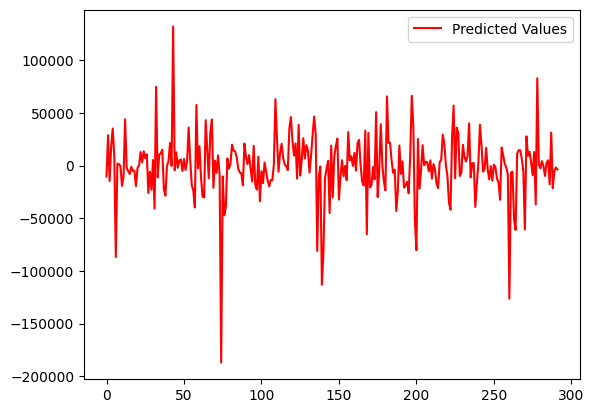

In [64]:
# Predict values and multiply by df1_max[-1]
predicted_values_flt = flt_model.predict(x_test_filtered).flatten() * df1_max[-1]

# Assuming y_test is a numpy array, multiply it by df1_max[-1] and flatten it
true_values = (y_test * df1_max[-1])

# Generate x-coordinates for the bars
x_coords_flt = range(len(predicted_values_flt))

# Plot the difference between predicted values and true values
plt.plot(x_coords_flt, predicted_values_flt - true_values, color='red', label='Predicted Values')

# Add legend and show plot
plt.legend()
plt.show()


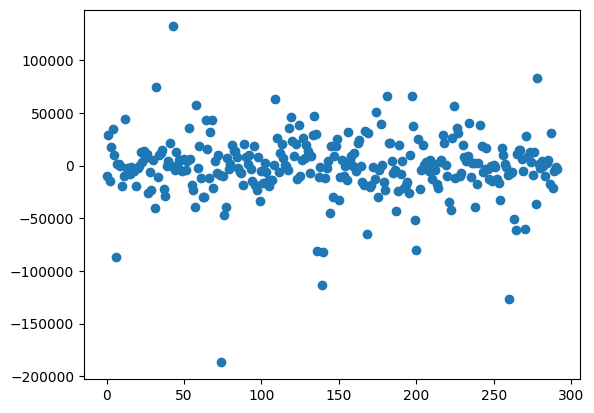

In [65]:
plt.scatter(x_coords_flt, predicted_values_flt - true_values)
plt.show()


In [69]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, predicted_values_flt/df1_max[-1])
print('R-squared:', r2)

R-squared: 0.8971893208168242


<ipython-input-70-1f28245dbc66>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predicted_values_flt - true_values, hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3}, color='blue')
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


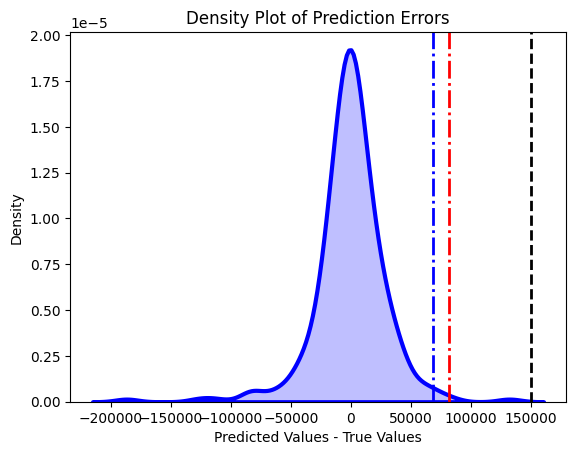

In [70]:
sns.distplot(predicted_values_flt - true_values, hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3}, color='blue')

# Add lines for the mean and standard deviation
mean = predicted_values_flt.mean()
std = predicted_values_flt.std()
plt.axvline(mean, color='black', linestyle='--', linewidth=2)
plt.axvline(std, color='red', linestyle='-.', linewidth=2)
plt.axvline(mean - std, color='blue', linestyle='-.', linewidth=2)

# Set labels and title
plt.xlabel('Predicted Values - True Values')
plt.ylabel('Density')
plt.title('Density Plot of Prediction Errors')

# Show the plot
plt.show()


#Conclusion

Our model 'flt_model' performs very well on the majority of the test data. However, it shows weaknesses towards data that is extremely different from the majority. This suggests the model might benefit from more training data encompassing a wider range of examples. With a more diverse dataset, the model could learn more generalized patterns and improve its performance on unseen data.

#Test csv DATA

##Import the data

In [83]:
#Take only the important features we chose for our model
imp_features = []
for ft,_ in filtered_features:
  imp_features.append(ft)

print(imp_features)

['MSSubClass', 'LotFrontage', 'Neighborhood', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'Exterior1st', 'BsmtExposure', 'BsmtFinType1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea']


In [84]:
test_df = pd.read_csv('/content/test.csv')
test_df = test_df[imp_features]
test_df.head()

MSSubClass  LotFrontage Neighborhood  OverallQual  OverallCond  YearBuilt  \
0          20         80.0        NAmes            5            6       1961   
1          20         81.0        NAmes            6            6       1958   
2          60         74.0      Gilbert            5            5       1997   
3          60         78.0      Gilbert            6            6       1998   
4         120         43.0      StoneBr            8            5       1992   

   YearRemodAdd Exterior1st BsmtExposure BsmtFinType1  TotalBsmtSF  1stFlrSF  \
0          1961     VinylSd           No          Rec        882.0       896   
1          1958     Wd Sdng           No          ALQ       1329.0      1329   
2          1998     VinylSd           No          GLQ        928.0       928   
3          1998     VinylSd           No          GLQ        926.0       926   
4          1992     HdBoard           No          ALQ       1280.0      1280   

   GrLivArea  GarageArea  
0        896       730.0  
1       1329       312.0  
2       1629       482.0  
3       1604       470.0  
4       1280       506.0

In [85]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSSubClass    1459 non-null   int64  
 1   LotFrontage   1232 non-null   float64
 2   Neighborhood  1459 non-null   object 
 3   OverallQual   1459 non-null   int64  
 4   OverallCond   1459 non-null   int64  
 5   YearBuilt     1459 non-null   int64  
 6   YearRemodAdd  1459 non-null   int64  
 7   Exterior1st   1458 non-null   object 
 8   BsmtExposure  1415 non-null   object 
 9   BsmtFinType1  1417 non-null   object 
 10  TotalBsmtSF   1458 non-null   float64
 11  1stFlrSF      1459 non-null   int64  
 12  GrLivArea     1459 non-null   int64  
 13  GarageArea    1458 non-null   float64
dtypes: float64(3), int64(7), object(4)
memory usage: 159.7+ KB


##Data Preprocessing

In [86]:
#Make all numerical data as float
to_float=['1stFlrSF','GarageArea','GrLivArea']
for col in to_float:
  test_df[col] = test_df[col].astype(float)

#numerical features
num_fts = test_df.select_dtypes(include=['float64']).columns.tolist()


#Make all categorical data as object
to_object = test_df.select_dtypes(include=['int64']).columns.tolist()
for col in to_object:
  test_df[col] = test_df[col].astype(object)

#categorical features
cat_fts = test_df.select_dtypes(include=['object']).columns.tolist()


In [87]:
test_df1 = test_df.copy()

#Fill numerical features with the mean
for col in num_fts:
  test_df1[col].fillna(test_df1[col].mean(), inplace=True)

#Fill categorical features with the mode
for col in cat_fts:
  test_df1[col].fillna(test_df1[col].mode()[0], inplace=True)



In [93]:
#Encoding the categorical features
for ft in cat_fts:
  test_df1[ft] = le.fit_transform(test_df1[ft])

In [94]:
test_df1.info()
test_df1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSSubClass    1459 non-null   int64  
 1   LotFrontage   1459 non-null   float64
 2   Neighborhood  1459 non-null   int64  
 3   OverallQual   1459 non-null   int64  
 4   OverallCond   1459 non-null   int64  
 5   YearBuilt     1459 non-null   int64  
 6   YearRemodAdd  1459 non-null   int64  
 7   Exterior1st   1459 non-null   int64  
 8   BsmtExposure  1459 non-null   int64  
 9   BsmtFinType1  1459 non-null   int64  
 10  TotalBsmtSF   1459 non-null   float64
 11  1stFlrSF      1459 non-null   float64
 12  GrLivArea     1459 non-null   float64
 13  GarageArea    1459 non-null   float64
dtypes: float64(5), int64(9)
memory usage: 159.7 KB


MSSubClass  LotFrontage  Neighborhood  OverallQual  OverallCond  YearBuilt  \
0           0         80.0            12            4            5         56   
1           0         81.0            12            5            5         53   
2           5         74.0             8            4            4         92   
3           5         78.0             8            5            5         93   
4          11         43.0            22            7            4         87   

   YearRemodAdd  Exterior1st  BsmtExposure  BsmtFinType1  TotalBsmtSF  \
0            11           10             3             4        882.0   
1             8           11             3             0       1329.0   
2            48           10             3             2        928.0   
3            48           10             3             2        926.0   
4            42            6             3             0       1280.0   

   1stFlrSF  GrLivArea  GarageArea  
0     896.0      896.0       730.0  
1    1329.0     1329.0       312.0  
2     928.0     1629.0       482.0  
3     926.0     1604.0       470.0  
4    1280.0     1280.0       506.0

##Normalize the data

In [95]:
test_df2 = test_df1.copy()
test_df_max = test_df2.max()
test_df2 = test_df2.divide(test_df_max)
test_df2.head()

MSSubClass  LotFrontage  Neighborhood  OverallQual  OverallCond  YearBuilt  \
0    0.000000        0.400      0.500000     0.444444        0.625   0.533333   
1    0.000000        0.405      0.500000     0.555556        0.625   0.504762   
2    0.333333        0.370      0.333333     0.444444        0.500   0.876190   
3    0.333333        0.390      0.333333     0.555556        0.625   0.885714   
4    0.733333        0.215      0.916667     0.777778        0.500   0.828571   

   YearRemodAdd  Exterior1st  BsmtExposure  BsmtFinType1  TotalBsmtSF  \
0      0.183333     0.833333           1.0           0.8     0.173111   
1      0.133333     0.916667           1.0           0.0     0.260844   
2      0.800000     0.833333           1.0           0.4     0.182139   
3      0.800000     0.833333           1.0           0.4     0.181747   
4      0.700000     0.500000           1.0           0.0     0.251227   

   1stFlrSF  GrLivArea  GarageArea  
0  0.175859   0.175859    0.490591  
1  0.260844   0.260844    0.209677  
2  0.182139   0.319725    0.323925  
3  0.181747   0.314818    0.315860  
4  0.251227   0.251227    0.340054

##Using our Model on the data

In [96]:
X_testing = test_df2.iloc[:, :]
predicted_prices = flt_model.predict(X_testing).flatten() * df1_max[-1]

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [98]:
# prompt: i want to change the display limit so i can see the whole array

import numpy as np
np.set_printoptions(threshold=np.inf)
print(predicted_prices)


[119336.21  146016.97  183323.48  196776.53  186017.94  174598.45
 167790.2   164598.12  205528.3   108463.69  180853.4    92928.305
  87236.6   135704.61  105930.08  389786.4   281204.03  301874.75
 310869.5   553260.94  379855.84  223093.39  188475.2   177570.17
 179583.    212935.77  335332.5   272947.97  198495.45  198991.94
 204490.45   81302.63  207197.11  282862.06  268297.12  244088.67
 171179.56  147868.64  152124.05  143553.52  154702.33  150341.1
 297101.34  267010.28  207330.83  186938.56  286214.22  189790.2
 152221.03  125132.43  122248.62  152029.89  138233.61  140758.6
 189721.1   150147.14  145784.56  107143.75  227333.39  111564.05
 113100.69  138980.58   92047.984 122411.13  105701.87   92974.484
  88754.445 139284.33  134563.17  177978.61   96286.81   73556.8
 145380.88   96537.26  124330.01   89200.32   37657.24  136875.03
 161557.33  101236.64  116253.01  168536.98  226844.75   78129.56
 133521.94  133352.1   149295.12  170911.25  101203.89  142568.03
  96773.22  